# Prices Simulation from Stooq API

We will see a simple example of how to simulated stock prices from some historical stocks prices dowload from the web.

## Download historical data

First we will download some historical stock prices from symbols (ticker), over date range, start to end. For this purpose we use the a library called ``pandas_datareader`` that allows us to download stocks prices from various API. Here we use the [Stooq](https://stooq.com/) finance datas.   

The historical stock prices are stored in the ``df_prices`` variable as a ``pd.DataFrame``.

In [1]:
from datetime import datetime
import pandas_datareader.data as web

stocks = ["ge", "intc", "amd", "gold", "spy", "ko", "pep"]
start, end = datetime(2017, 1, 1), datetime(2020, 1, 1)
df = web.DataReader(stocks, "stooq", start=start, end=end)
prices = df["Close"]

## Make a prevision on the anual expected return

We define expected annual returns as a dictionary that we called ``era`` and a number of simulated prices ``spn`` to be predicted for each previously downloaded stock. We intentionally chose an unreal expected return like -0.8 for the *ge* ticker and -0.99 for the *spy* Ticker to stress the simulation.

In [2]:
ear = {
    "ge": -0.8,
    "intc": 10,
    "amd": -0.1,
    "gold": -0.5,
    "spy": -0.99,
    "ko": 0.08,
    "pep": 0.01,
}
spn = 254

## Simulate the future prices

1. Check that the ``prices`` DataFrame contains prices using the ``Assets`` object.


In [3]:
from qoptimiza.assets import Assets
from qoptimiza.simulation.simulation import Simulation

stocks_history = Assets(df=prices)

2. Create the ``simulation`` instance of the ``Simulation`` class.

In [4]:
simulation = Simulation(stocks_history, er=ear, ns=spn)

3. Make the simulation with the given historical stock prices, the anual expected returns and the numbers of days. The results is a ``tuple`` containing future returns, covariance and prices respectively names ``future_returns``, ``future_cov``, ``future_prices``.

In [5]:
from loguru import logger

logger.disable("qoptimiza")

future_prices = simulation(order=12)

4. Plot the historical prices follow by the simulated ones on the same plot.

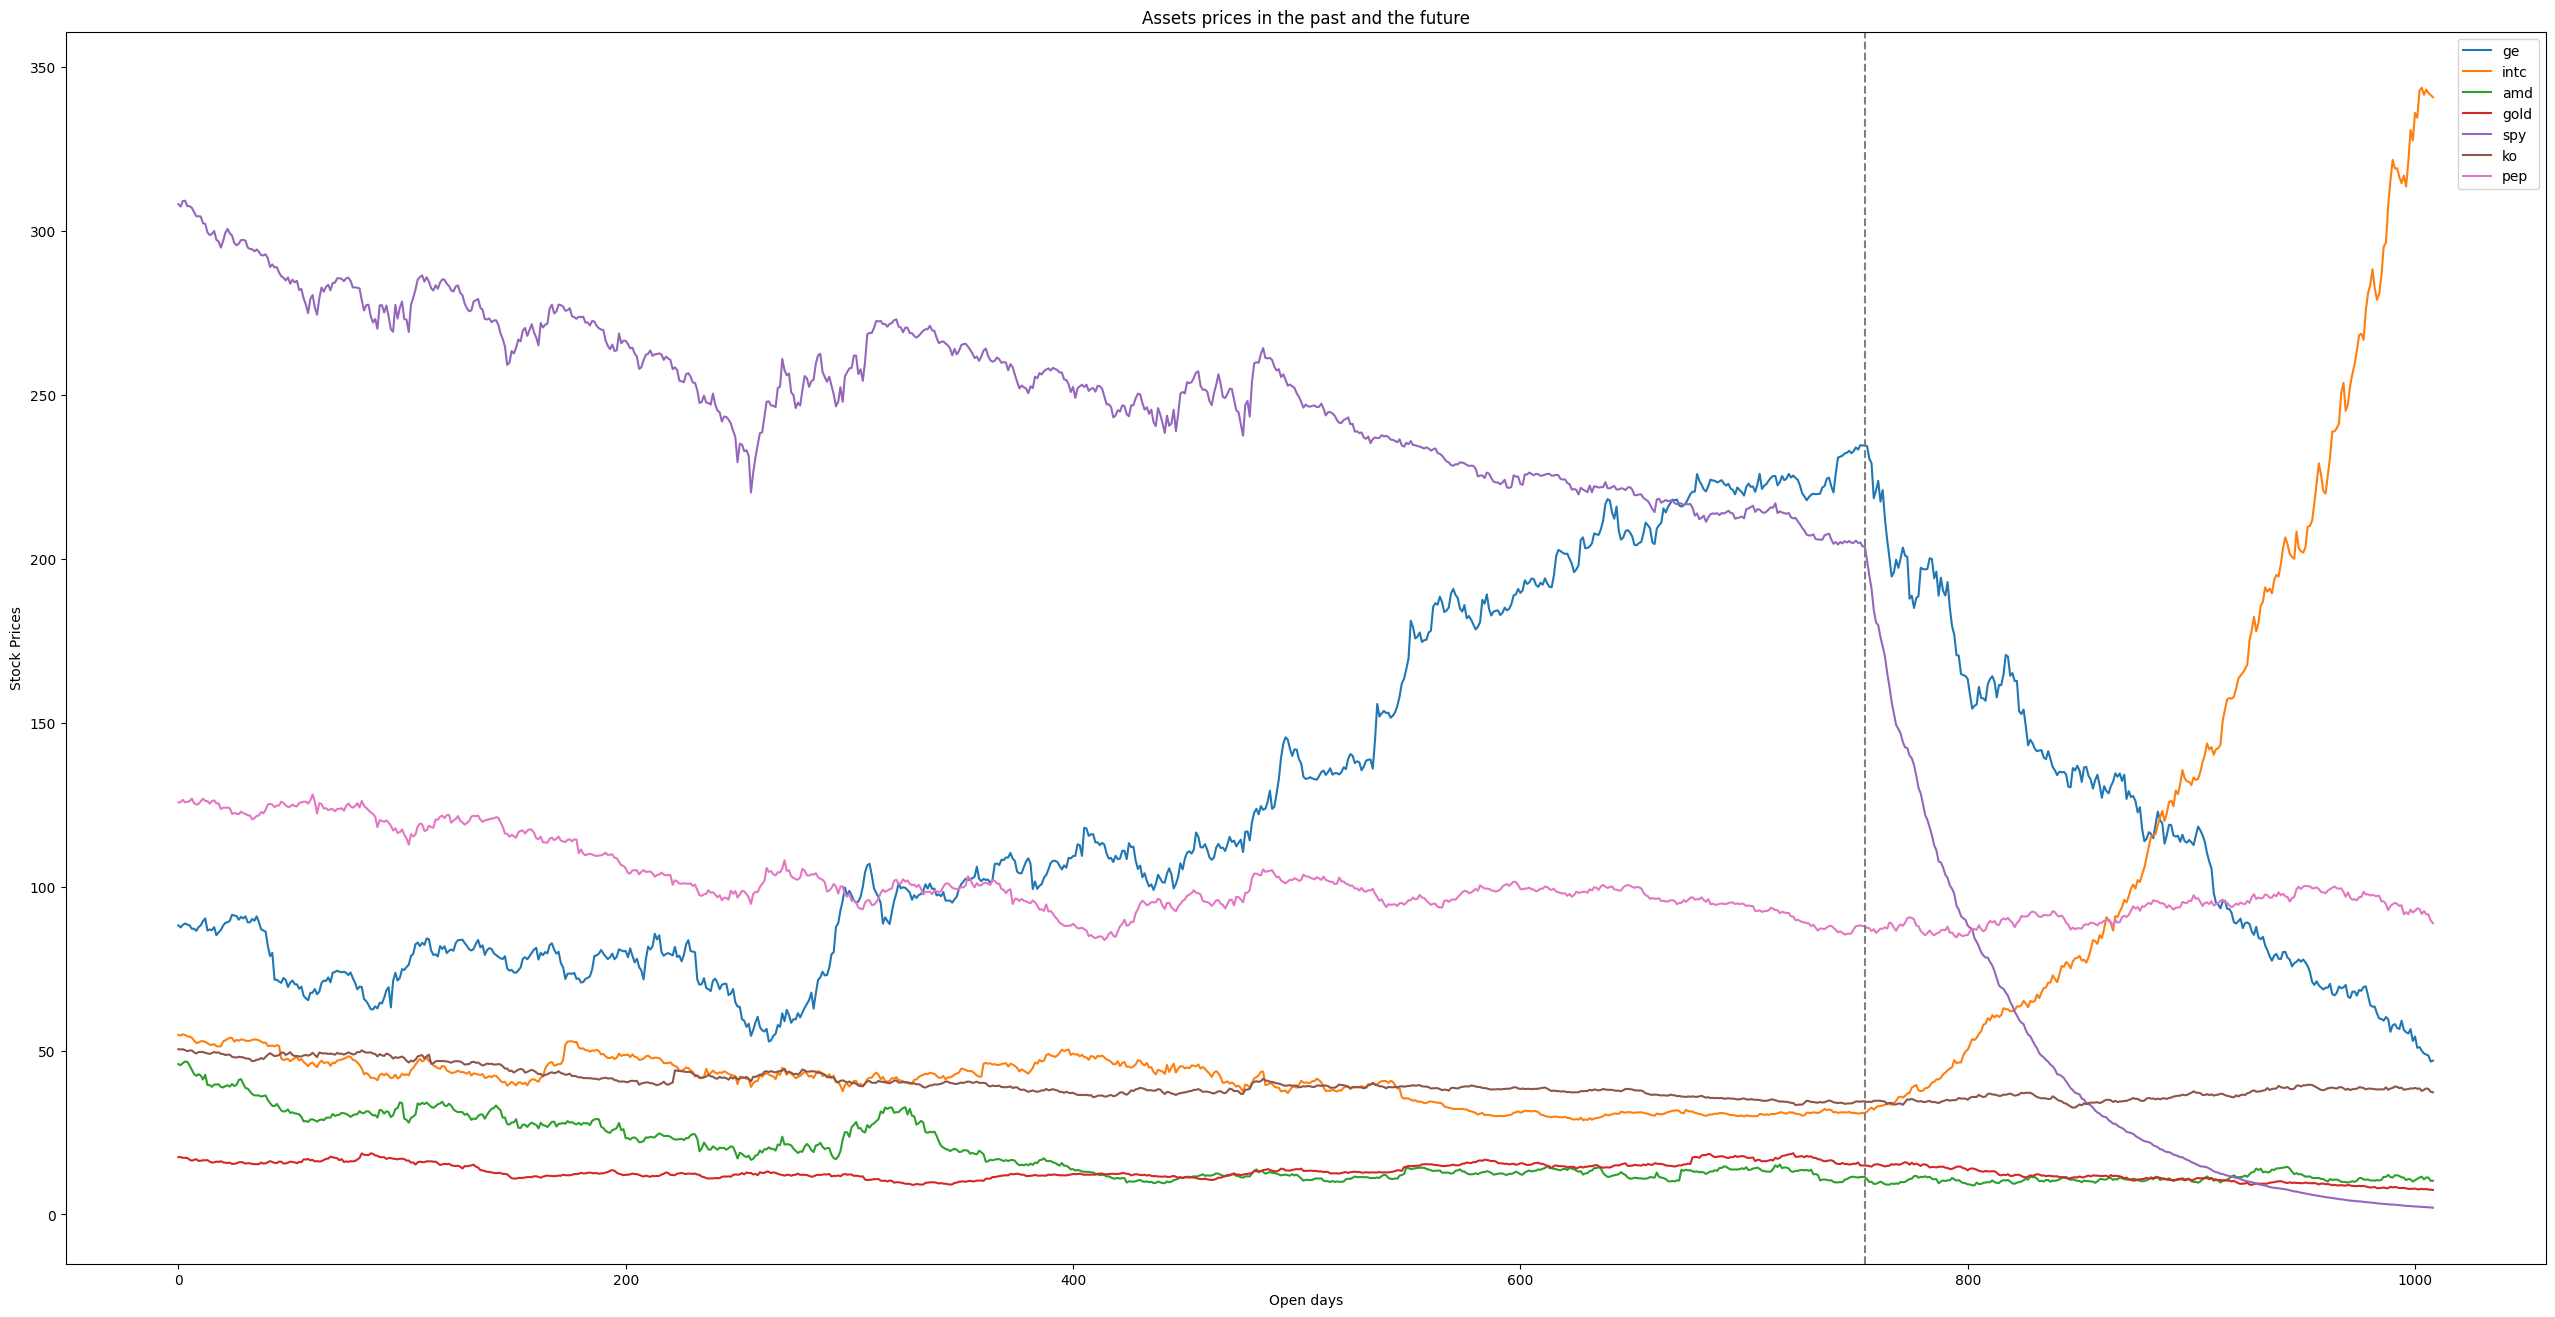

In [6]:
import numpy as np
import matplotlib.pyplot as plt

prices = np.vstack((stocks_history.prices, future_prices.prices))  # shape (nh + nf, k)

fig, ax = plt.subplots(figsize=(32, 16))
ax.set_title("Assets prices in the past and the future")
ax.plot(prices, label=stocks_history.df.columns)
ax.axvline(x=stocks_history.n, ymin=0, ymax=1, c="grey", linestyle="--")
ax.set_xlabel("Open days")
ax.set_ylabel("Stock Prices")
ax.legend();

## Verify the quality of the results

To be sure that all is as expected we verify that:

1. The covariance of the daily returns of our simulated prices are the same as the historical one.  

In [7]:
import numpy as np

np.testing.assert_allclose(future_prices.cov, stocks_history.cov)

2. The simulated anual returns are the same as the desired anual returns.  
    For that the `Simulation` class first reorder the `ear` dictionary in order to ensure that all the values of `simulation.er` correspond to the same asset as the `future_prices.anual_returns` value.

In [8]:
np.testing.assert_allclose(future_prices.anual_returns, simulation.er)